In [33]:
import pandas as pd 
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize 
from sklearn import linear_model
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
#from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange

In [34]:
# make some fake data with approximately the same sample size 
size_Open = 110
size_Designed = 350

#make up some probabilities for different outcomes 
p_open_persist = 0.3
p_open_pivot = 0.3
p_open_perish = 1 - p_open_persist - p_open_pivot

p_designed_persist = 0.3
p_designed_pivot = 0.6
p_designed_perish = 1 - p_designed_persist - p_designed_pivot

x_open = np.random.multinomial(size_Open, [p_open_perish, p_open_pivot, p_open_persist])
x_designed = np.random.multinomial(size_Designed, [p_designed_perish, p_designed_pivot, p_designed_persist])

print(x_open)
print(x_designed)

# calculate chi-squared for the fake data 
stat, p, dof, expected = stats.chi2_contingency([x_designed, x_open])# ddof = 2)
print(stat)
print(p)
print(dof)
print(expected)

[35 39 36]
[ 29 202 119]
41.26898453674554
1.0928331765338522e-09
2
[[ 48.69565217 183.36956522 117.93478261]
 [ 15.30434783  57.63043478  37.06521739]]


In [35]:
# create one test dataframe
test_Open = np.vstack((np.ones(size_Open), np.hstack((np.ones(x_open[0]), 2*np.ones(x_open[1]), 3*np.ones(x_open[2])))))
test_Designed = np.vstack((np.zeros(size_Designed), np.hstack((np.ones(x_designed[0]), 2*np.ones(x_designed[1]), 3*np.ones(x_designed[2])))))
testData = np.transpose(np.hstack((test_Open, test_Designed)))
testData = pd.DataFrame(data = testData, columns = ['OpenDummy', 'predicted'])
print(testData.head())
testData['predicted'].value_counts()

   OpenDummy  predicted
0        1.0        1.0
1        1.0        1.0
2        1.0        1.0
3        1.0        1.0
4        1.0        1.0


2.0    241
3.0    155
1.0     64
Name: predicted, dtype: int64

In [36]:
# solve the basic mnl function
mdl = sm.MNLogit(testData.predicted, testData.OpenDummy)
mdl_fit = mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 1.098357
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:              predicted   No. Observations:                  460
Model:                        MNLogit   Df Residuals:                      458
Method:                           MLE   Df Model:                            0
Date:                Mon, 08 Jul 2019   Pseudo R-squ.:                 -0.1212
Time:                        14:57:48   Log-Likelihood:                -505.24
converged:                       True   LL-Null:                       -450.63
                                        LLR p-value:                       nan
predicted=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
OpenDummy       0.1082      0.233      0.465      0.642      -0.348       0.565
--------------------------

In [37]:
# add some fake funding, starte date year data
testData['awardAmount'] = np.random.randint(100000, high = 5000000, size = (size_Open+size_Designed)) 
testData['startingYear'] = np.random.randint(0, high = 9, size = (size_Open+size_Designed)) # models work with scaled from 0 data, but not real years 
print(testData.head())

   OpenDummy  predicted  awardAmount  startingYear
0        1.0        1.0      4466070             4
1        1.0        1.0      2521169             3
2        1.0        1.0       704062             5
3        1.0        1.0      1248358             4
4        1.0        1.0      2446795             5


In [32]:
# solve the basic mnl function
# having convergence issues 
print(type(testData))
exog = testData[['OpenDummy', 'startingYear']]
#print(exog.head())
#mdl = sm.MNLogit(testData.predicted, exog)
#mdl_fit = mdl.fit()
#print(mdl_fit.summary())

<class 'numpy.ndarray'>


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
# create a test data dataframe
test_Open= np.vstack((np.ones(size_Open), np.hstack((np.ones(x_open[0]), np.zeros(x_open[1]+x_open[2])))))
test_Designed = np.vstack((np.zeros(size_Designed), np.hstack((np.ones(x_designed[0]), np.ones(x_designed[1]+x_designed[2])))))
testData = np.transpose(np.hstack((test_Open, test_Designed)))
testdfPersist = pd.DataFrame(data = testData, columns = ['category', 'predicted'])

test_Open= np.vstack((np.ones(size_Open), np.hstack((np.ones(x_open[1]), np.zeros(x_open[0]+x_open[2])))))
test_Designed = np.vstack((np.zeros(size_Designed), np.hstack((np.ones(x_designed[1]), np.ones(x_designed[0]+x_designed[2])))))
testData = np.transpose(np.hstack((test_Open, test_Designed)))
testdfPivot = pd.DataFrame(data = testData, columns = ['category', 'predicted'])

test_Open= np.vstack((np.ones(size_Open), np.hstack((np.ones(x_open[2]), np.zeros(x_open[0]+x_open[1])))))
test_Designed = np.vstack((np.zeros(size_Designed), np.hstack((np.ones(x_designed[2]), np.ones(x_designed[0]+x_designed[1])))))
testData = np.transpose(np.hstack((test_Open, test_Designed)))
testdfPerish = pd.DataFrame(data = testData, columns = ['category', 'predicted'])

In [3]:
#does binomial make sense? --> check this

model = sm.formula.glm("predicted ~ C(category)",
                       family=sm.families.Binomial(), data=testdfPersist).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              predicted   No. Observations:                  460
Model:                            GLM   Df Residuals:                      458
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -57.706
Date:                Mon, 24 Jun 2019   Deviance:                       115.41
Time:                        10:13:53   Pearson chi2:                     110.
No. Iterations:                    24                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.5661   1.15e+04      0.002      0.998   -2.26e+04    2.27e+04
C(category)[T.1.0]   -24.289

In [67]:
model = sm.formula.glm("predicted ~ C(category)",
                       family=sm.families.Binomial(), data=testdfPivot).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              predicted   No. Observations:                  460
Model:                            GLM   Df Residuals:                      458
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -74.031
Date:                Wed, 19 Jun 2019   Deviance:                       148.06
Time:                        17:39:51   Pearson chi2:                     110.
No. Iterations:                    24                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.5661   1.15e+04      0.002      0.998   -2.26e+04    2.27e+04
C(category)[T.1.0]   -25.160

In [7]:
dir(model)
model.params[0]
model.pvalues[0]
model.bse #standard error 
x = model.conf_int(alpha = 0.05, cols = None)
lb = x[0]
ub = x[1]

In [8]:
r_length = 40
r = np.arange(r_length)
r = r[1:]
s = np.arange(10)
s = s[1:]
interceptDataHolder = np.zeros((39,3,9))
slopeDataHolder = np.zeros((39,3,9))
pvalHolder = np.zeros((39,1,9))
for q in range(s.shape[0]):
    p_other = s[q-1]/10
    for m in range(r.shape[0]):
        p_open = r[m-1]/40
        testOpenvar = np.random.binomial(size=size_Open, n=1, p=p_open)
        testOthervar = np.random.binomial(size=size_Other, n=1, p=p_other)
        testOpen2 = np.ones(size_Open,)
        testOther2 = np.zeros(size_Other,)
        testOpen = np.vstack((testOpenvar, testOpen2))
        testOther = np.vstack((testOthervar, testOther2))
        testData = (np.hstack((testOpen, testOther)))
        testData2 = np.transpose(testData)
        testdf = pd.DataFrame(data = testData2, columns = ['predicted', 'category'])
        model = sm.formula.glm("predicted ~ C(category)",
                       family=sm.families.Binomial(), data=testdf).fit()
        x = model.conf_int(alpha = 0.05, cols = None)
        lb = x[0]
        ub = x[1]
        interceptDataHolder[m-1,0,q-1] = model.params[0]
        interceptDataHolder[m-1,1,q-1] = lb[0]
        interceptDataHolder[m-1,2,q-1] = ub[0]
        slopeDataHolder[m-1,0,q-1] = model.params[1]
        slopeDataHolder[m-1,1,q-1] = lb[1]
        slopeDataHolder[m-1,2,q-1] = ub[1]
        pvalHolder[m-1,0,q-1]=model.pvalues[1]

NameError: name 'size_Other' is not defined

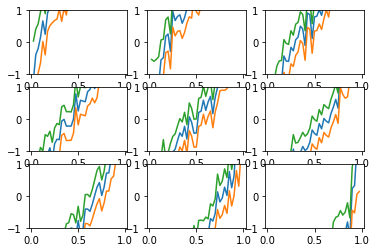

In [21]:
plt.figure(1)
for n in range(9):
    plotNum = 331 + n
    plt.subplot(plotNum)
    plt.plot(r/r_length, slopeDataHolder[0:r_length-1,0,n])
    plt.plot(r/r_length, slopeDataHolder[0:r_length-1,1,n])
    plt.plot(r/r_length, slopeDataHolder[0:r_length-1,2,n])
    plt.ylim(-1, 1)
plt.show()

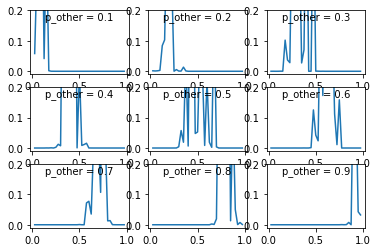

In [22]:
figLabels = ['p_other = 0.1', 'p_other = 0.2', 'p_other = 0.3', 'p_other = 0.4', 'p_other = 0.5', 
            'p_other = 0.6', 'p_other = 0.7', 'p_other = 0.8', 'p_other = 0.9']
plt.figure(2)
for n in range(9):
    plotNum = 331 + n
    plt.subplot(plotNum)
    plt.plot(r/r_length, pvalHolder[0:r_length-1,0,n])
    plt.text(0.5, 0.17, figLabels[n], horizontalalignment = 'center')
    plt.ylim(-0.01, 0.2)
plt.show()

In [23]:
open_length = 10
op = np.arange(open_length)
op = op[1:]*25
diffs = np.array([0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5])
interceptDataHolder = np.zeros((int(diffs.shape[0]), 3, open_length-1))
slopeDataHolder = np.zeros((int(diffs.shape[0]), 3, open_length-1))
pvalHolder = np.zeros((int(diffs.shape[0]), 1, open_length-1))
testHolder = np.zeros((int(diffs.shape[0]), 1, open_length-1))
for q in range(diffs.shape[0]):
    p_other = 0.4
    p_open = p_other + diffs[q-1]
    for m in range(op.shape[0]):
        testOpenvar = np.random.binomial(size=op[m-1], n=1, p=p_open)
        testOthervar = np.random.binomial(size=op[m-1]*4, n=1, p=p_other)
        testOpen2 = np.ones(op[m-1],)
        testOther2 = np.zeros(op[m-1]*4,)
        testOpen = np.vstack((testOpenvar, testOpen2))
        testOther = np.vstack((testOthervar, testOther2))
        testData = (np.hstack((testOpen, testOther)))
        testData2 = np.transpose(testData)
        testdf = pd.DataFrame(data = testData2, columns = ['predicted', 'category'])
        model = sm.formula.glm("predicted ~ C(category)",
                       family=sm.families.Binomial(), data=testdf).fit()
        x = model.conf_int(alpha = 0.05, cols = None)
        lb = x[0]
        ub = x[1]
        testHolder[q-1, 0, m-1] = p_open
        interceptDataHolder[q-1,0,m-1] = model.params[0]
        interceptDataHolder[q-1,1,m-1] = lb[0]
        interceptDataHolder[q-1,2,m-1] = ub[0]
        slopeDataHolder[q-1,0,m-1] = model.params[1]
        slopeDataHolder[q-1,1,m-1] = lb[1]
        slopeDataHolder[q-1,2,m-1] = ub[1]
        pvalHolder[q-1,0,m-1]=model.pvalues[1]

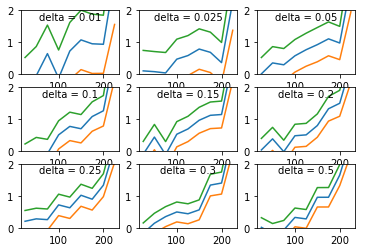

In [24]:
figLabels = ['delta = 0.01', 'delta = 0.025', 'delta = 0.05', 'delta = 0.1', 
             'delta = 0.15', 'delta = 0.2', 'delta = 0.25', 'delta = 0.3', 'delta = 0.5']
plt.figure(3)
for n in range(9):
    x = 331+n
    plt.subplot(x)
    plt.plot(op, slopeDataHolder[:,0,n])
    plt.plot(op, slopeDataHolder[:,1,n])
    plt.plot(op, slopeDataHolder[:,2,n])
    plt.text(125, 1.7, figLabels[n], horizontalalignment = 'center')
    plt.ylim(-0, 2)

plt.show()

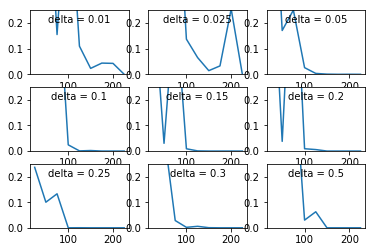

In [25]:
figLabels = ['delta = 0.01', 'delta = 0.025', 'delta = 0.05', 'delta = 0.1', 
             'delta = 0.15', 'delta = 0.2', 'delta = 0.25', 'delta = 0.3', 'delta = 0.5']
plt.figure(4)
for n in range(9):
    x = 331+n
    plt.subplot(x)
    plt.plot(op, pvalHolder[:,0,n])
    plt.text(125, 0.2, figLabels[n], horizontalalignment = 'center')
    plt.ylim(0, 0.25)
plt.show()

In [32]:
monteCarloRuns = 1000
open_length = 10
op = np.arange(open_length)
op = op[1:]*25
diffs = np.array([0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5])
interceptDataHolder = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
slopeDataHolder = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
interceptDataHolderlb = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
slopeDataHolderlb = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
interceptDataHolderub = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
slopeDataHolderub = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
pvalHolder = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
testHolder = np.zeros((int(diffs.shape[0]), monteCarloRuns, open_length-1))
for a in range(monteCarloRuns):
    for q in range(diffs.shape[0]):
        p_other = 0.4
        p_open = p_other + diffs[q-1]
        for m in range(op.shape[0]):
            testOpenvar = np.random.binomial(size=op[m-1], n=1, p=p_open)
            testOthervar = np.random.binomial(size=op[m-1]*4, n=1, p=p_other)
            testOpen2 = np.ones(op[m-1],)
            testOther2 = np.zeros(op[m-1]*4,)
            testOpen = np.vstack((testOpenvar, testOpen2))
            testOther = np.vstack((testOthervar, testOther2))
            testData = (np.hstack((testOpen, testOther)))
            testData2 = np.transpose(testData)
            testdf = pd.DataFrame(data = testData2, columns = ['predicted', 'category'])
            model = sm.formula.glm("predicted ~ C(category)",
                                   family=sm.families.Binomial(), data=testdf).fit()
            x = model.conf_int(alpha = 0.05, cols = None)
            lb = x[0]
            ub = x[1]
            interceptDataHolder[q-1,a,m-1] = model.params[0]
            interceptDataHolderlb[q-1,a,m-1] = lb[0]
            interceptDataHolderub[q-1,a,m-1] = ub[0]
            slopeDataHolder[q-1,a,m-1] = model.params[1]
            slopeDataHolderlb[q-1,a,m-1] = lb[1]
            slopeDataHolderub[q-1,a,m-1] = ub[1]
            pvalHolder[q-1,a,m-1]=model.pvalues[1]

In [27]:
plotPval = np.percentile(pvalHolder, 50, axis=1)
plotPvallb = np.percentile(pvalHolder, 2.5, axis=1)
plotPvalub = np.percentile(pvalHolder, 97.5, axis=1)

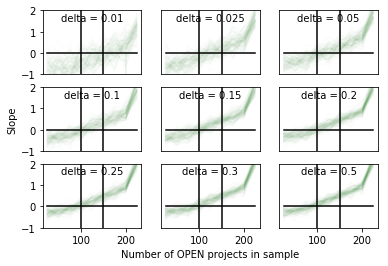

In [28]:
figLabels = ['delta = 0.01', 'delta = 0.025', 'delta = 0.05', 'delta = 0.1', 
             'delta = 0.15', 'delta = 0.2', 'delta = 0.25', 'delta = 0.3', 'delta = 0.5']
fig = plt.figure(5)
for n in range(9):
    x = 331+n
    plt.subplot(x)
    #plt.plot(op, slopeDataHolder[:,:,n], color='blue', alpha = 0.01)
    plt.plot(op, slopeDataHolderlb[:,:,n], color='green', alpha = 0.01)
    #plt.plot(op, slopeDataHolderub[:,:,n], color='red', alpha = 0.01)
    plt.text(125, 1.5, figLabels[n], horizontalalignment = 'center')
    plt.ylim(-1, 2)
    plt.plot([25, 225], [0, 0], color='black')
    plt.plot([100, 100], [-1, 3], color = 'black')
    plt.plot([150, 150], [-1, 3], color = 'black')
    if n == 3:
        plt.ylabel('Slope')
    if n == 7:
        plt.xlabel('Number of OPEN projects in sample')
    if n < 6:
        plt.xticks([])
    if n%3 != 0:
        plt.yticks([])
plt.show()
fig.savefig('2.5pctileSlopeData.png', bbox_inches='tight')

In [29]:
slopeDataHolderlb.shape[0]
x = slopeDataHolderlb[3,:,:]
x.shape[0]
y = np.zeros(9,)
for n in range(x.shape[0]):
    for m in range(x.shape[1]):
        if x[n,m] > 0:
            y[m] = y[m] + 1
y = y/x.shape[0]
y

array([ 0.16,  0.25,  0.4 ,  0.4 ,  0.52,  0.61,  0.67,  0.65,  0.78])

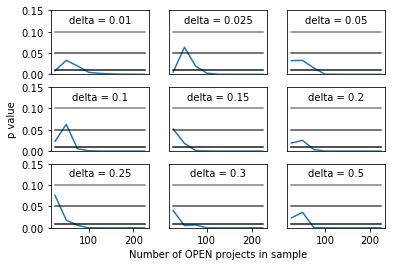

In [30]:
figLabels = ['delta = 0.01', 'delta = 0.025', 'delta = 0.05', 'delta = 0.1', 
             'delta = 0.15', 'delta = 0.2', 'delta = 0.25', 'delta = 0.3', 'delta = 0.5']
fig = plt.figure(6)
for n in range(9):
    x = 331+n
    plt.subplot(x)
    #plt.plot(op, plotPval[:,n])
    plt.plot(op, plotPvallb[:,n])
    #plt.plot(op, plotPvalub[:,n])
    plt.text(125, 0.12, figLabels[n], horizontalalignment = 'center')
    plt.ylim(0, 0.15)
    plt.plot([25, 225], [0.1, 0.1], color='black', alpha= 0.5)
    plt.plot([25, 225], [0.05, 0.05], color='black', alpha= 0.7)
    plt.plot([25, 225], [0.01, 0.01], color='black', alpha= 0.9)
    if n == 3:
        plt.ylabel('p value')
    if n == 7:
        plt.xlabel('Number of OPEN projects in sample')
    if n < 6:
        plt.xticks([])
    if n%3 != 0:
        plt.yticks([])
plt.show()
fig.savefig('p-value_variation_with_sample_size.png', bbox_inches='tight')

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
effect_size = 0.2
alpha = 0.05
power = 0.8
#nobs1 = 332
ratio = 112/353
#power_analysis = sm.TTestIndPower()
power_analysis = sm.
sample_size = power_analysis.solve_power(
    #effect_size = effect_size, 
    power = power, 
    alpha = alpha, 
    ratio = ratio, 
    nobs1 = 350)
print('Required sample size:{0:.2f}'.format(sample_size))

#sample_size = power_analysis.solve_power(effect_size = effect_size, alpha = alpha, )

SyntaxError: invalid syntax (<ipython-input-3-fbf6ee68cdfd>, line 7)

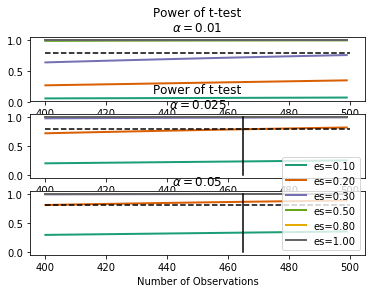

In [4]:
fig = plt.figure()
ax = fig.add_subplot(3,1,1)
fig = sm.TTestIndPower().plot_power(dep_var = 'nobs', 
                                    nobs = np.arange(400,500),
                                    ratio = 112/353, 
                                    effect_size = np.array([0.1, 0.2, 0.3, 0.5, 0.8,1]), 
                                    alpha = 0.01, ax = ax, 
                                    title = 'Power of t-test'+'\n'+r'$\alpha = 0.01$')
plt.plot([400, 500], [0.8, 0.8], '--k')
ax.get_legend().remove()

ax = fig.add_subplot(3,1,2)
fig = sm.TTestIndPower().plot_power(dep_var = 'nobs', 
                                    nobs = np.arange(400,500), 
                                    effect_size = np.array([0.1, 0.2, 0.3, 0.5, 0.8,1]), 
                                    alpha = 0.025, ax = ax, 
                                    title = 'Power of t-test'+'\n'+r'$\alpha = 0.025$')
plt.plot([400, 500], [0.8, 0.8], '--k')
plt.plot([465, 465], [0,1], '-k')
ax.get_legend().remove()

ax = fig.add_subplot(3,1,3)
fig = sm.TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(400, 500),
                                 effect_size=np.array([0.1, 0.2, 0.3, 0.5, 0.8,1]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
plt.plot([400, 500], [0.8, 0.8], '--k')
plt.plot([465, 465], [0,1], '-k')
#fig.subplots_adjust(top = 1.4)
plt.show()

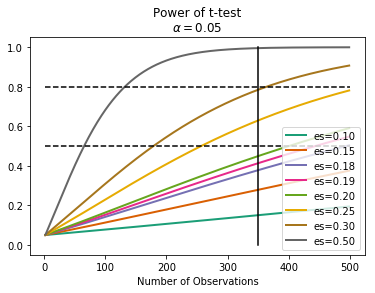

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig = sm.TTestIndPower().plot_power(dep_var = 'nobs', 
                                    nobs = np.arange(2,500), 
                                    ratio = 112/353,
                                    effect_size = np.array([0.1, 0.15, 0.18, 0.19, 0.2, 0.25, 0.3, 0.5]), 
                                    alpha = 0.05, ax = ax, 
                                    title = 'Power of t-test'+'\n'+r'$\alpha = 0.05$')
plt.plot([2, 500], [0.5, 0.5], '--k')
plt.plot([2, 500], [0.8, 0.8], '--k')
plt.plot([350,350], [0,1], '-k')
plt.show()

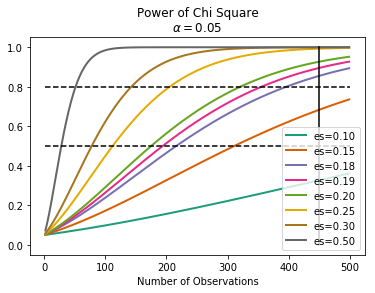

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig = sm.GofChisquarePower().plot_power(dep_var = 'nobs', 
                                    nobs = np.arange(2,500), 
                                    effect_size = np.array([0.1, 0.15, 0.18, 0.19, 0.2, 0.25, 0.3, 0.5]), 
                                    alpha = 0.05, ax = ax, n_bins = 6, ddof = 2, 
                                    title = 'Power of Chi Square'+'\n'+r'$\alpha = 0.05$')
plt.plot([2, 500], [0.5, 0.5], '--k')
plt.plot([2, 500], [0.8, 0.8], '--k')
plt.plot([450,450], [0,1], '-k')
plt.show()

In [12]:
# make a sample bar chart for poster with coded project data
# the dummy data will change for actual poster
dummyData = np.array([[14, 20, 27, 51, 112],[17, 23, 30, 283, 353]])

# andlingerColors = 

fig = plt.figure(figsize = (8.5,5.5))
plt.rcParams.update({'font.size': 18})
plt.bar([0.3,1.3,2.3, 3.3, 4.3], dummyData[0,:], width = 0.4)
plt.bar([0.7, 1.7, 2.7, 3.7, 4.7], dummyData[1,:], width = 0.4)
for n in range(4):
    val = round(100*dummyData[0,n]/dummyData[0,-1],0)
    plt.text(n+0.3, dummyData[0,n]+5, str(val)+'%', HorizontalAlignment = 'center', fontsize = 12)
    val = round(100*dummyData[1,n]/dummyData[1,-1],0)
    plt.text(n+0.7, dummyData[1,n]+5, str(val)+'%', HorizontalAlignment = 'center', fontsize = 12)    
plt.xticks(np.arange(5)+0.5, ('Persist', 'Pivot', 'Perish', 'To Code', 'Total'))
plt.legend(('OPEN', 'Designed'))
plt.ylabel('Number of Projects')
plt.title('Project outcomes by program type')
#plt.text(2, 200, 'FAKE DATA REPLACE LATER', color = 'green', HorizontalAlignment = 'center')
plt.savefig('barChart.png', dpi=300)